In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from pylab import rcParams

from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.api import Holt


from pyramid.arima import auto_arima

%matplotlib inline
rcParams['figure.figsize'] = 11, 9
pd.set_option('display.max_rows', 500)


C:\Users\amayb\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#reading data
data = pd.read_excel("OpsData.xlsx", sheetname='Data')
data.head()

,Customer Number,Customer Name,Month,Year,QTY,Extended Price
0,3800,American Eagle - Canada,1,2009,3828,75410.67
1,3800,American Eagle - Canada,2,2009,3557,63183.61
2,3800,American Eagle - Canada,3,2009,5432,50366.96
3,3800,American Eagle - Canada,4,2009,4097,102930.35
4,3800,American Eagle - Canada,5,2009,5811,125204.41


In [3]:
def data_prep(customer_name_string,dataframe):
    #takes sales data, sorts by company and returns new frame with sales data 
    df = data.loc[data['Customer Name']==customer_name_string,:].copy()
    df['Day'] = 1
    df['Date'] = pd.to_datetime(df[['Year','Month','Day']])
    df.set_index(df['Date'],inplace=True)
    df.drop(['Customer Number','Customer Name', 'Month','Year','Day','Extended Price','Date'],axis = 1,inplace=True)

    return df

In [4]:
#set up data
disney = data_prep('Disney Store Canada Inc',data)
winners = data_prep('Winners Merchants International',data)


In [5]:
#training and test data for both companies
disney_train = disney.loc[:'2016-12-01']
disney_test = disney.loc['2017-01-01':]

winners_train = winners.loc[:'2016-12-01']
winners_test = winners.loc['2017-01-01':]


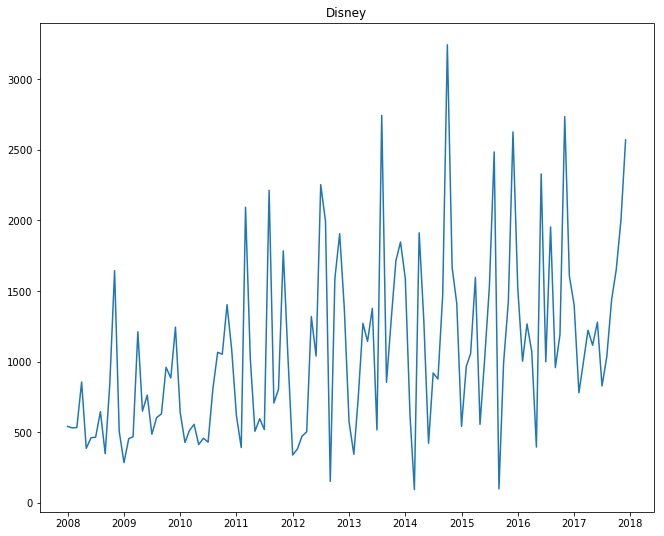

In [6]:
plt.plot(disney)
plt.title('Disney')

In [7]:
disney.describe()

,QTY
count,120.000000
mean,1074.800000
std,641.805156
min,93.000000
25%,538.000000
50%,989.000000
75%,1415.500000
max,3244.000000


The data for disney seems to follow a fairly normal trend with seasonality

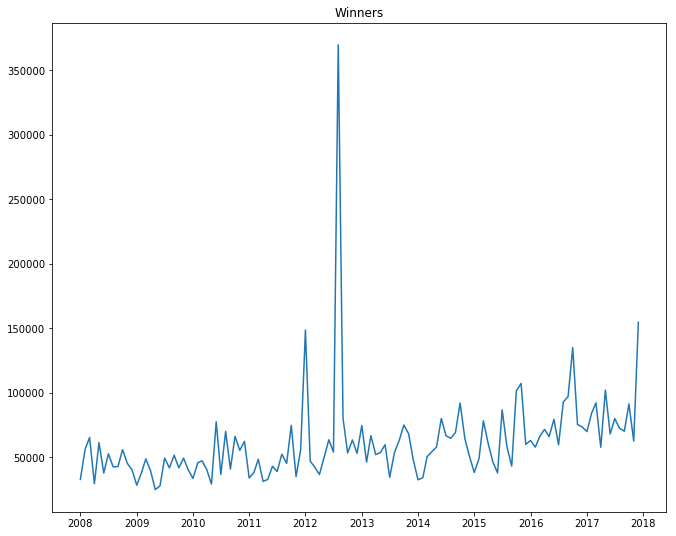

In [8]:
plt.plot(winners)
#plt.plot(winners.values.max)
plt.title('Winners')

In [9]:
winners.idxmax()

QTY   2012-08-01
dtype: datetime64[ns]

In [10]:
winners.describe()

,QTY
count,120.000000
mean,61364.883333
std,36382.212017
min,24970.000000
25%,42505.750000
50%,54826.500000
75%,69413.750000
max,369612.000000


After reviewing the plot of winners data we can see that there is a fairly disruptive outlier.

In [11]:
winners.idxmax()
#this is the month where the anomoly occurs


QTY   2012-08-01
dtype: datetime64[ns]

The outlier occurs on August of 2012, this value will be replaced by the mean of all other August quantities.

In [12]:
#replacing the outlier with average QTY for other Augusts
new_winners_value = int(winners[(winners.index.month==8) & (winners.index !='2012-08-01')].mean())

winners.loc[winners.index == '2012-08-01','QTY'] =new_winners_value


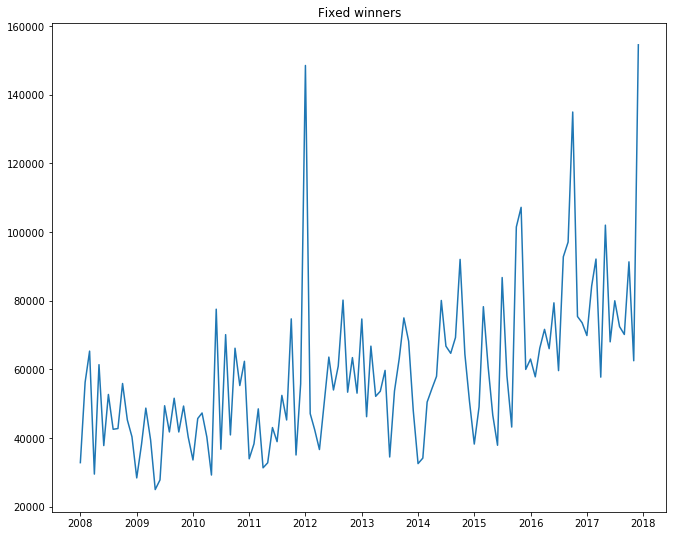

In [13]:
plt.plot(winners)
plt.title('Fixed winners')

There is still an outlier here so we will impute again

In [14]:
new_winners_value2 = int(winners[(winners.index.month==12) & (winners.index !='2012-01-01')].mean())

winners.loc[winners.index == '2012-01-01','QTY'] =new_winners_value2

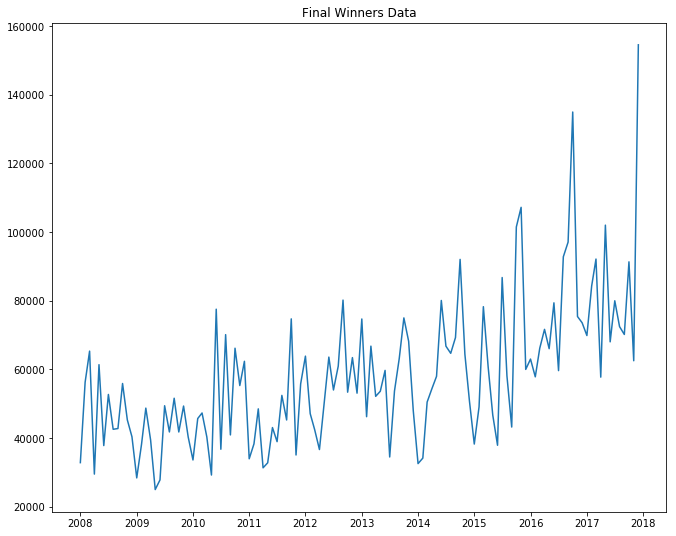

In [15]:
plt.plot(winners)
plt.title('Final Winners Data')

Winners data with outlier removed

In [16]:
def results(predictions,test):
    #takes prediction and test data sets and returns dataframe with results + Abs dev and % error
    results = pd.DataFrame({'Forecast':predictions,'Actual':test.loc[:,'QTY']},index=test.index)
    results['Absolute Deviation'] = abs(results['Actual']-results['Forecast'])
    results['Percent Error'] = (abs(results['Actual']-results['Forecast'])/abs(results['Actual']))*100
    
    return results

In [17]:
def results_plot(train,test,results):
    #plots original data and the predicted data
    plt.plot(test,'g')
    plt.plot(train)
    plt.plot(results['Forecast'],'r')
    plt.legend(['Test','Train','Forecast'])
    plt.title('Actual and Forecast')
    plt.xlabel("Year")
    plt.ylabel('Quantity')
    

#Disney Moving Average

In [18]:
disney_ma =disney_train.loc[:,'QTY'].rolling(3).mean()[-1]
disney_ma_results = results(disney_ma,disney_test)

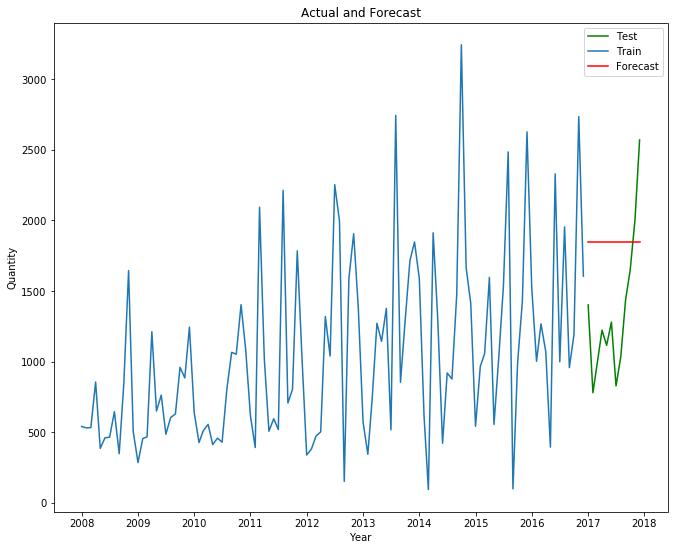

In [19]:
results_plot(disney_train,disney_test,disney_ma_results)
plt.savefig('disney ma')

#Winners Moving Average

In [20]:
winners_ma =winners_train.loc[:,'QTY'].rolling(3).mean()[-1]
winners_ma_results = results(winners_ma,winners_test)


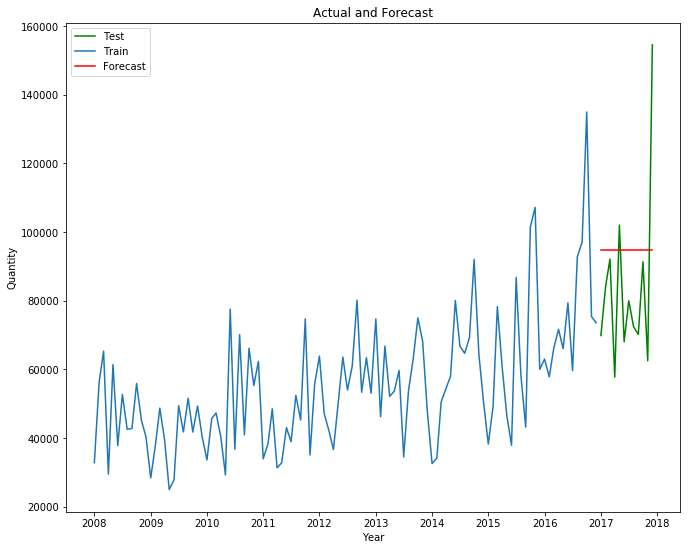

In [21]:
results_plot(winners_train,winners_test,winners_ma_results)
plt.savefig('winner ma')

Both Disney and Winners Moving Average fits are rather poor. 

#Disney Exponential Smoothing

In [22]:
disney_ewm = disney_train.loc[:,'QTY'].ewm(alpha=0.7,adjust=False).mean()[-1]
disney_ewm_results = results(disney_ewm,disney_test)

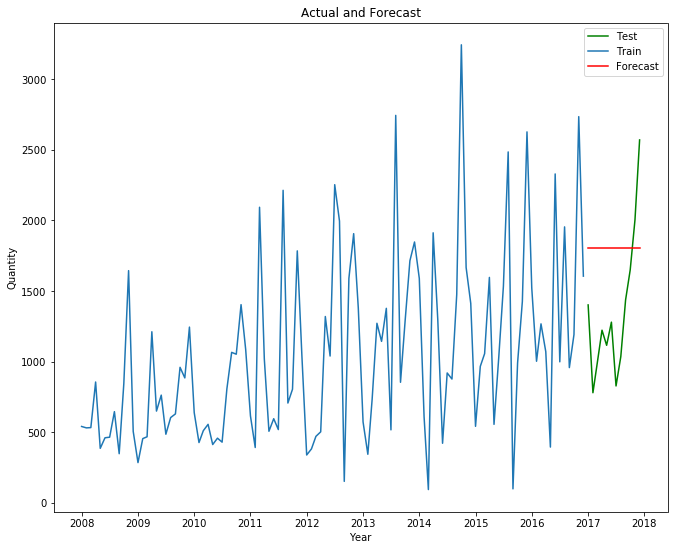

In [23]:
results_plot(disney_train,disney_test,disney_ewm_results)
plt.savefig('disney ewm')

#Winners Exponential Smoothing

In [24]:
winners_ewm = winners_train.loc[:,'QTY'].ewm(alpha=.7,adjust=False).mean()[-1]
winners_ewm_results = results(winners_ewm,disney_test)


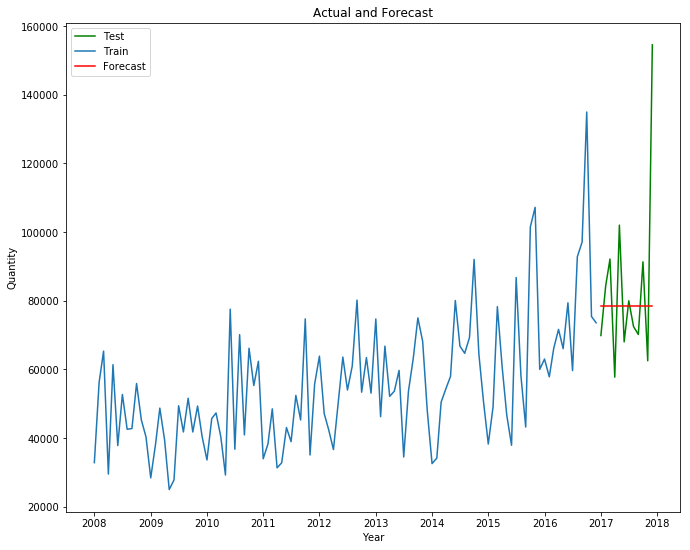

In [25]:
results_plot(winners_train,winners_test,winners_ewm_results)
plt.savefig('winner ewm')

Exponential smoothing fit for Disney is quite bad, however it is slightly better for Winners. Since both Moving Average and Exponential Smoothing models are not correctly capturing the trend and seasonality that are expressed in the Disney and Winners data, we will explore a model that is adept at doing so, the ARIMA. 

In [26]:

def decomp(dataframe):
    #returns a seasonal decomposition of data
    result = seasonal_decompose(dataframe, model = 'additive')
    result.plot()

  

# Seasonal Decomposition for Disney

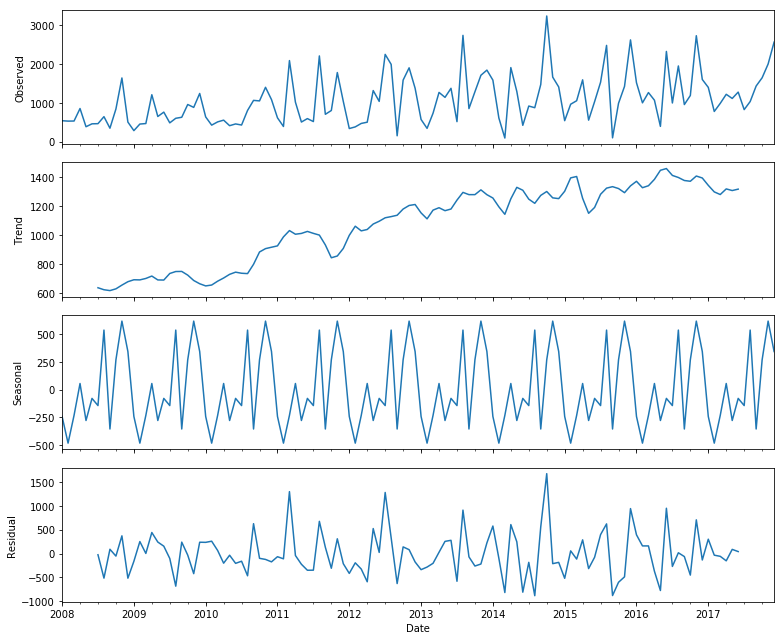

In [27]:
decomp(disney)
plt.savefig('Disney Decomp')

By looking at the decomposition graphs above a clear seasonal affect and a trend are observed in Disney's data

# Seasonal Decomposition for Winners

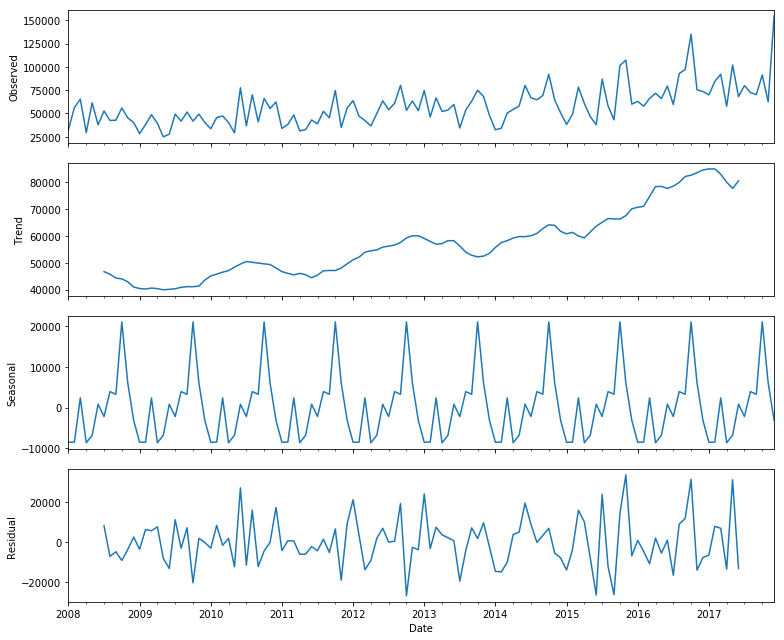

In [28]:
decomp(winners)
plt.savefig('Winners decomp')

For winners, trend and seasonality are also noted. 

# Notes on the ARIMA Model

-  **AR (P)** - This term refers to how many past values are used in the time series forecast
-  **I (d)** - This term is the differencing component. Differencing is done to correct inaacuracies in the seasonality of a series. Differencing is accomplished by subtracting a set previous number of time from the current time of the forecast
-  **MA (q)** - Moving Average

**Seasonal** terms of the ARIMA(p,d,q)**(P,D,Q)** help to fit models with seasonality, meaning models that do not have stationary data, such as the data displayed by both Disney and Winners.

In [29]:
#fitting disney model
disney_arima = auto_arima(disney, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=False)

disney_fit = disney_arima.fit(disney_train) 
disney_arima

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(3, 1, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

The Disney Data was fit with a seasonal arima model ARIMA(3,1,1)(0,1,1)12

In [30]:
#fitting winners model
winners_arima = auto_arima(winners, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=False)

winners_fit = winners_arima.fit(winners_train)
winners_arima

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(1, 1, 3),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

The Winners data was fit with a seasonal ARIMA model ARIMA(1,1,2)(0,1,1)12

In [31]:
#predictions made by models fit on training data
disney_predict = disney_fit.predict(n_periods=12)
winners_predict= winners_fit.predict(n_periods=12)

In [32]:
disney_arima_results = results(disney_predict,disney_test)

In [33]:
winners_arima_results= results(winners_predict,winners_test)

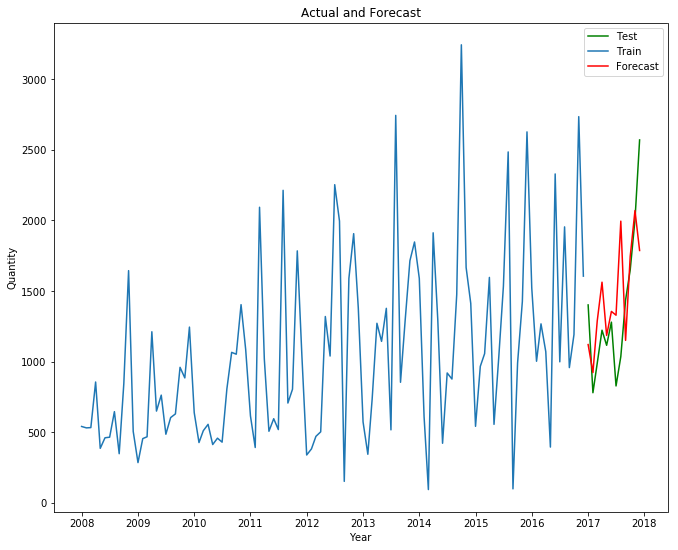

In [34]:
results_plot(disney_train,disney_test,disney_arima_results)
plt.savefig('Disney Arima')

Disney ARIMA

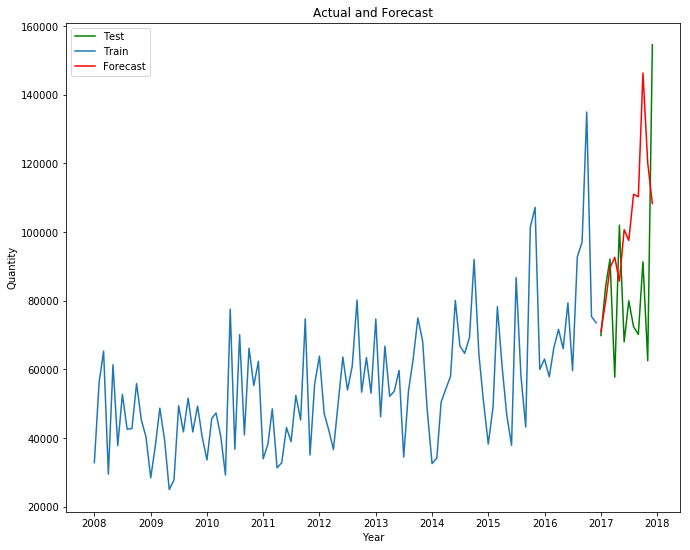

In [35]:
results_plot(winners_train,winners_test,winners_arima_results)
plt.savefig('Winner arima')

Winners ARIMA

In [36]:
#Setting up results table for Disney
results_list_disney = [disney_arima_results,disney_ma_results,disney_ewm_results]
results_list_disney_MAD = [results['Absolute Deviation'].mean() for results in results_list_disney]
results_list_disney_MAPE = [results['Percent Error'].mean() for results in results_list_disney]


In [37]:
#Setting up results table for Winners
results_list_winners = [winners_arima_results,winners_ma_results,winners_ewm_results]
results_list_winners_MAD = [results['Absolute Deviation'].mean() for results in results_list_winners]
results_list_winners_MAPE = [results['Percent Error'].mean() for results in results_list_winners]


In [38]:
#Disney results frame
disney_final_results = pd.DataFrame({'Model':['ARIMA','Moving Average','Exponential Smoothing'],
                                      'MAD':results_list_disney_MAD,
                                      'MAPE':results_list_disney_MAPE
                                    })
disney_final_results = disney_final_results[['Model','MAD','MAPE']]


In [39]:
#Winners results frame
winners_final_results = pd.DataFrame({'Model':['ARIMA','Moving Average','Exponential Smoothing'],
                                      'MAD':results_list_winners_MAD,
                                      'MAPE':results_list_winners_MAPE
                                    })
winners_final_results = winners_final_results[['Model','MAD','MAPE']]


# Disney Results

In [40]:
disney_final_results

,Model,MAD,MAPE
0,ARIMA,325.049634,26.796325
1,Moving Average,632.694444,57.730815
2,Exponential Smoothing,606.963127,55.126566


# Winners Results

In [41]:
winners_final_results

,Model,MAD,MAPE
0,ARIMA,28944.101177,37.421975
1,Moving Average,22112.944444,28.214887
2,Exponential Smoothing,77000.737336,6346.999742


In [57]:
disney_future = auto_arima(disney, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=False).fit(disney)
disney_future_predictions = disney_future.predict(n_periods =12)

# Future predictions for Disney

In [96]:
dis = pd.DataFrame(disney_future_predictions,columns=['Predictions'],index=pd.date_range('2018-01-01',periods=12,freq= 'MS'))
#dis.to_excel('Disney future predictions.xlsx')
dis

,Predictions
2018-01-01,1146.261497
2018-02-01,815.030500
2018-03-01,1092.879290
2018-04-01,1524.420852
2018-05-01,1183.997805
2018-06-01,1336.987990
2018-07-01,1235.100713
2018-08-01,1859.228540
2018-09-01,1137.048749
2018-10-01,1698.699121


# Future Predictions for Winners

In [97]:
winners_future =winners_test.loc[:,'QTY'].rolling(3).mean()[-1]
win = pd.DataFrame(winners_future,columns=['Winners future predictions'], index= pd.date_range('2018-01-01',periods=12,freq= 'MS'))
#win.to_excel('Winners future predictions.xlsx')
win

,Winners future predictions
2018-01-01,102805.666667
2018-02-01,102805.666667
2018-03-01,102805.666667
2018-04-01,102805.666667
2018-05-01,102805.666667
2018-06-01,102805.666667
2018-07-01,102805.666667
2018-08-01,102805.666667
2018-09-01,102805.666667
2018-10-01,102805.666667


# Conclusion

It is clear for Disney through visually exploring the predictions and their corresponding MAD and MAPE scores that the ARIMA Model is the best fit. This is not the case for the Winners data, even though it exhibits both trend and seasonality that would make it the perfect candidate for ARIMA. Possible explanations could be the fact that the data still follows trend and seasonality, but becomes more and more amplified towards the very end of the data collection.